In [1]:
%load_ext autoreload
%autoreload 2
from fastai.fastai.text import *
import pickle

In [2]:
chunksize=24000

## Classifier Training

In [3]:
fold_index = 2   # fold_index+1 is accessed

In [4]:
# these are the indexes of the text based on vocab

ids_train = np.load('results_rakesh/tok_inds_npy/cls_ids_train_f' + str(fold_index+1) + '.npy')
ids_test = np.load('results_rakesh/tok_inds_npy/cls_ids_test_f' + str(fold_index+1) + '.npy')

In [5]:
ids_train.shape

(25811,)

In [6]:
info_train = pd.read_csv('results_rakesh/one_doc_df/doc_info_train_f'
                         + str(fold_index+1) + '.csv', index_col=0)
info_test = pd.read_csv('results_rakesh/one_doc_df/doc_info_test_f'
                        + str(fold_index+1) + '.csv', index_col=0)
info_train.head(3)

,label,1day_ret,article_id,gvkey,date
0,0,0.000900,1124027,020779:01,2008-02-07
1,0,0.020017,1124371,008479:01,2008-02-07
2,-1,-0.026510,1131224,120877:01,2008-02-07


In [7]:
lbl_train = info_train["label"].values
lbl_test = info_test["label"].values
lbl_train.shape

(25811,)

In [8]:
itos = pickle.load(Path('Transcript_Data/itos.pkl').open('rb'))
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

60002

In [9]:
lbl_train = lbl_train + 1
lbl_test = lbl_test + 1

In [10]:
lbl_train[:5]

array([1, 1, 0, 2, 1])

In [11]:
bptt,em_sz,nh,nl = 70,400,1150,3   # back prop through time, embedding size, num hidden neuron, num layers
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48   # batch size

In [12]:
# sortist sampler just sorts the texts to have the longest text first

ds_train = TextDataset(ids_train, lbl_train)
ds_test = TextDataset(ids_test, lbl_test)
samp_train = SortishSampler(ids_train, key=lambda x: len(ids_train[x]), bs=bs//2)
samp_test = SortSampler(ids_test, key=lambda x: len(ids_test[x]))
dl_train = DataLoader(ds_train, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=samp_train)
dl_test = DataLoader(ds_test, bs, transpose=True, num_workers=1, pad_idx=1, sampler=samp_test)
md = ModelData(Path('results_rakesh/nn_models/'), dl_train, dl_test)

In [13]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])

In [14]:
# this creates a model object? what are the parameters here?
# c is # of classes, vs is vocab size, layers is num neurons per layer?
# you mean during training when adjusting weights it is looking at 20*70 words
# in the forward pass
# and then while calculating gradients only 70
# so in the prediction it uses 20*70 words then since there is no backprop for prediction?

c = 3
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [15]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [16]:
# what is the difference between RNN_Learnings and get_rnn_classifier
# RNN_Learner is a general RNN learner - to which you give m

learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [20]:
# learning rates init for each layer - will be calculated

lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [21]:
# same as above

lrs=np.array([1e-4,1e-4,1e-4,1e-3,1e-2])

In [22]:
# what is wd? this is weight decay

wd = 1e-7
wd = 0
learn.load_encoder('lm1_enc')

In [20]:
# freeze first layer and learn? or last layer

learn.freeze_to(-1)

 79%|███████▉  | 852/1076 [22:18<05:51,  1.57s/it, loss=4.3]  

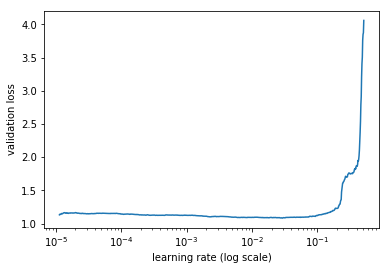

In [21]:
# find learning rate

learn.lr_find(lrs/1000)
learn.sched.plot()

In [26]:
learn.get_layer_groups()

[(Embedding(60002, 400, padding_idx=1), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(400, 1150)
  ), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(1150, 1150)
  ), LockedDropout(
  )), (WeightDrop(
    (module): LSTM(1150, 400)
  ), LockedDropout(
  )), PoolingLinearClassifier(
   (layers): ModuleList(
     (0): LinearBlock(
       (lin): Linear(in_features=1200, out_features=50, bias=True)
       (drop): Dropout(p=0.4)
       (bn): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True)
     )
     (1): LinearBlock(
       (lin): Linear(in_features=50, out_features=3, bias=True)
       (drop): Dropout(p=0.1)
       (bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True)
     )
   )
 )]

In [41]:
# fitting steps 
# A. freeze all but -1, 1 epoch
# B. freeze all but -2 and -1, 1 epoch
# C. unfreeze all and train 6 epochs

learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.075444   1.08199    0.427797  


[array([1.08199]), 0.42779680392513536]

In [42]:
learn.save('clas_0_f' + str(fold_index+1) + '')

In [43]:
learn.load('clas_0_f' + str(fold_index+1) + '')

In [44]:
learn.freeze_to(-2)

In [49]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                     
    0      1.089554   1.077106   0.431507  


[array([1.07711]), 0.431506849110943]

In [50]:
learn.save('clas_1_f' + str(fold_index+1) + '')

In [23]:
learn.load('clas_1_f' + str(fold_index+1) + '')

In [24]:
learn.unfreeze()

In [25]:
# even 6 epochs may be too lesss?

learn.fit(lrs, 1, wds=wd, cycle_len=4, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                     
    0      1.080094   1.07265    0.432078  
    1      1.082167   1.072278   0.429224                     
    2      1.07212    1.069412   0.426941                     
    3      1.078203   1.068903   0.428082                     



[array([1.0689]), 0.42808219096431993]

In [ ]:
learn.fit(lrs, 1, wds=wd, cycle_len=6, use_clr=(32,10))

epoch      trn_loss   val_loss   accuracy                     
    0      1.076635   1.1266     0.395263  
    1      1.073954   1.092947   0.41153                      
    2      1.086845   1.077565   0.428368                     
    3      1.080189   1.070514   0.425799                     
 55%|█████▍    | 588/1076 [24:41<20:29,  2.52s/it, loss=1.07] 

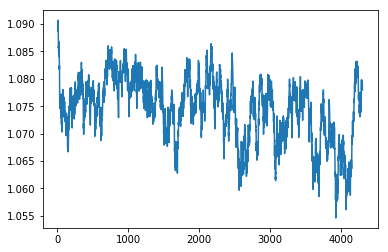

In [26]:
learn.sched.plot_loss()

In [27]:
learn.save('clas_2_f' + str(fold_index+1) + '')

## Evaluate IC?

In [28]:
from scipy.stats import spearmanr

In [29]:
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

In [30]:
# fold_index = 4
fold_index

2

In [32]:
ids_test = np.load('results_rakesh/tok_inds_npy/cls_ids_test_f' + str(fold_index+1) + '.npy')
info_test = pd.read_csv('results_rakesh/one_doc_df/doc_info_test_f'
                        + str(fold_index+1) + '.csv', index_col=0)
lbl_test = info_test["label"].values
ds_test = TextDataset(ids_test, lbl_test)
info_test.head(5)

,label,1day_ret,article_id,gvkey,date
0,1,0.045434,1443021,024352:01,2012-01-04
1,-1,-0.029125,1442763,010840:01,2012-01-04
2,-1,-0.103440,1444712,010353:01,2012-01-04
3,0,-0.021495,1384659,162129:01,2012-01-05
4,0,-0.024947,1443938,140760:01,2012-01-05


In [33]:
bptt,em_sz,nh,nl = 70,400,1150,3
vs = 60002
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [34]:
dl_test = DataLoader(ds_test, bs, transpose=True, num_workers=1, pad_idx=1)
md = ModelData(Path('results_rakesh/nn_models/'), None, dl_test)

In [35]:
c = 3
dps = np.array([0.4,0.5,0.05,0.3,0.4])
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1])

In [36]:
# intialize learner model - but weights are loaded from trained model below

learn = RNN_Learner(md, TextModel(to_gpu(m)))
learn.metrics = [accuracy]

In [37]:
# loading weights from trained model

print ('clas_2_f' + str(fold_index+1))
learn.load('clas_2_f' + str(fold_index+1))

clas_2_f3


In [38]:
# prediction - takes a bit of time (~10 mins) to complete!

result = learn.predict()    # dl_test is the input to model data object md

In [40]:
print ("Completed test results")

Completed test results


In [41]:
result = softmax(result, axis=1)

In [42]:
# put results in
info_test["pred-"] = result[:,0]
info_test["pred0"] = result[:,1]
info_test["pred+"] = result[:,2]
info_test["pred_sub"] = result[:,2] - result[:,0]

In [43]:
info_test.head(5)

,label,1day_ret,article_id,gvkey,date,pred-,pred0,pred+,pred_sub
0,1,0.045434,1443021,024352:01,2012-01-04,0.282042,0.394094,0.323864,0.041822
1,-1,-0.029125,1442763,010840:01,2012-01-04,0.305955,0.398010,0.296035,-0.009920
2,-1,-0.103440,1444712,010353:01,2012-01-04,0.206979,0.541856,0.251165,0.044186
3,0,-0.021495,1384659,162129:01,2012-01-05,0.306637,0.350904,0.342458,0.035821
4,0,-0.024947,1443938,140760:01,2012-01-05,0.306146,0.359782,0.334072,0.027926


In [44]:
# save
info_test.to_csv('results_rakesh/test_results/test_doc_f' + str(fold_index+1) + '.csv', index=False)

In [46]:
spearmanr(info_test["1day_ret"], info_test["pred_sub"])

SpearmanrResult(correlation=0.06552994793955094, pvalue=0.0001036830260581208)

In [47]:
spearmanr(info_test["1day_ret"], info_test["pred+"])

SpearmanrResult(correlation=-0.01893321716048928, pvalue=0.26252432326339603)

#### ran the models and tested above by Rakesh

#### this section is to aggregate by gvkey and date...?

In [40]:
from collections import defaultdict
def col_doc_results(doc_df):
    ret_dict = {}
    pred_dict = defaultdict(list)
    gv_dict = {}
    date_dict = {}
#     pd.DataFrame(columns=["gvkey", "date", "ret", "pred"])
    for i, row in doc_df.iterrows():
        key = row["gvkey"] + "_" + row["date"]
        if(key not in ret_dict):
            ret_dict[key] = row["ret"]
            gv_dict[key] = row["gvkey"]
            date_dict[key] = row["date"]
        pred_dict[key].append(row["pred_sub"])
    return ret_dict, pred_dict, gv_dict, date_dict

In [41]:
ret, pred, gvdict, datedict = col_doc_results(info_test)

In [42]:
ret_values = []
pred_values = []
gv_values = []
date_values = []
for key in ret:
    ret_values.append(ret[key])
    pred_values.append(np.mean(pred[key]))
    gv_values.append(gvdict[key])
    date_values.append(datedict[key])

In [43]:
spearmanr(ret_values, pred_values)

SpearmanrResult(correlation=0.046409668456836965, pvalue=0.005499897435725016)

In [44]:
event_result = pd.DataFrame({"gvkey":gv_values, "date":date_values, "ret":ret_values, "pred":pred_values})

In [45]:
event_result.head(5)

,gvkey,date,ret,pred
0,004560:01,2013-01-03,0.029836,0.002313
1,011600:01,2013-01-03,0.010128,0.017154
2,010840:01,2013-01-03,-0.017856,-0.037007
3,162129:01,2013-01-04,-0.005704,0.023294
4,025357:01,2013-01-04,0.027231,-0.048935


In [46]:
event_result.to_csv('Transcript_Data/10day/results_3cls/test_event_f' + str(fold_index+1) + '.csv', index=False)

In [ ]:
aggregation_functions = {'ret': 'first', 'pred_sub': 'mean', "pred+": "mean"}
newdf = info_test.groupby(["gvkey","date"]).aggregate(aggregation_functions)
newdf.head(5)

## colapse doc results to event - OLD METHOD

In [32]:
ret_train = pd.read_csv('Transcript_Data/1day/ret_1d_all/train_f' + str(fold_index+1) + '.csv',
                        parse_dates=[2], index_col=0)
ret_test = pd.read_csv('Transcript_Data/1day/ret_1d_all/test_f' + str(fold_index+1) + '.csv',
                       parse_dates=[2], index_col=0)

In [17]:
ret_test.head(5)

,gvkey,date,fwd_ret,fwd_ret_category
0,016453:01,2011-01-04,-0.081032,-1
0,162129:01,2011-01-05,-0.027223,-1
1,004560:01,2011-01-05,0.014818,0
2,011600:01,2011-01-05,-0.001175,0
3,023697:01,2011-01-05,-0.064765,-1


In [18]:
art_map = pd.read_csv("Transcript_Data/transcript_mapping.csv", index_col=0, parse_dates=[13])
art_map.head(3)

,gvkey,CUSIP,SEDOL,TIC,ISIN,transcript_id,factset_entity_Id,fsym_id,proper_name,fsym_primary_listing_id,ticker_region,company_id,event_date
0,002710:02,21036P108,2170473,STZ,US21036P1084,1048233,000CN7-E,QZ2Q0V-S,"Constellation Brands, Inc. Class A",RK3HS8-R,STZ-US,818,2007-01-04
1,008902:01,749685103,2756174,RPM,US7496851038,1047794,000VLT-E,DF312T-S,RPM International Inc.,LN3YSL-R,RPM-US,1299,2007-01-04
2,009472:01,808194104,2779342,SHLM,US8081941044,1048056,000VS7-E,TSDFC1-S,"A. Schulman, Inc.",CRJZ1Y-R,SHLM-US,2518,2007-01-04


In [19]:
art_path = Path("Transcript_Data/transcripts.pkl")
art_dict = pickle.load(open(art_path, "rb"))

In [20]:
pred_return = []
true_return = []
counter = 0
for i, row in ret_test.iterrows():
    label = row['one_day_ret']
    gvkey = row['gvkey']
    date = row['date']
    indx = (art_map['gvkey'] == gvkey) & (art_map['event_date'] == date)
    num_doc = sum(indx)  # number of document for event
    if num_doc == 0:
        continue
    
    art_ids = art_map[indx]['transcript_id']

    filt_ids = []
    for id in art_ids:
        if id in art_dict:
            filt_ids.append(id)
    num_doc = len(filt_ids)
    
    if num_doc == 0:
        continue
        
    result_set = result[counter:counter + num_doc, 1]
#         print(result_set)
    true_return.append(label)
    pred_return.append( np.mean(result_set) )
#     print(true_return)
#     print(pred_return)
#     break
    counter += num_doc
    if i % 500 == 0:
        print(str(counter) + " " + str(len(result)))

1 3448
2 3448
9 3448
16 3448
29 3448
32 3448
36 3448
40 3448
50 3448
68 3448
89 3448
118 3448
126 3448
176 3448
232 3448
333 3448
394 3448
410 3448
463 3448
513 3448
620 3448
692 3448
703 3448
756 3448
815 3448
895 3448
938 3448
981 3448
1115 3448
1167 3448
1202 3448
1356 3448
1423 3448
1443 3448
1478 3448
1503 3448
1557 3448
1560 3448
1573 3448
1587 3448
1622 3448
1626 3448
1642 3448
1654 3448
1658 3448
1659 3448
1663 3448
1671 3448
1685 3448
1691 3448
1697 3448
1704 3448
1708 3448
1713 3448
1719 3448
1722 3448
1733 3448
1735 3448
1737 3448
1740 3448
1754 3448
1764 3448
1793 3448
1840 3448
1971 3448
2070 3448
2201 3448
2406 3448
2528 3448
2550 3448
2666 3448
2796 3448
2985 3448
3175 3448
3205 3448
3222 3448
3229 3448
3233 3448
3243 3448
3257 3448
3278 3448
3294 3448
3299 3448
3304 3448
3316 3448
3333 3448
3340 3448
3348 3448
3352 3448
3358 3448
3370 3448
3378 3448
3380 3448
3381 3448
3385 3448
3387 3448
3394 3448
3397 3448
3405 3448
3416 3448
3422 3448
3423 3448
3426 3448
3437 3448
34

In [21]:
len(pred_return)

3412

In [22]:
from scipy.stats import spearmanr

In [23]:
spearmanr(pred_return, true_return)

SpearmanrResult(correlation=0.006701956576526852, pvalue=0.6955475371557087)

In [ ]:
pred_return

In [ ]:
true_return